In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import stat
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima   

/Users/kieranodonnell/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/kieranodonnell/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
bmd = pd.read_csv('building_metadata.csv')

In [4]:
#Investigating building use
bmd['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [5]:
#There is a healthcare category -> making new DF for it

In [6]:
hlth = bmd[bmd['primary_use']=='Healthcare']

In [7]:
hlth.sort_values('square_feet', ascending=False)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
365,3,365,Healthcare,819577,1922.0,NaN
556,3,556,Healthcare,450000,2012.0,NaN
1072,13,1072,Healthcare,305000,NaN,NaN
1243,14,1243,Healthcare,237704,NaN,NaN
1286,14,1286,Healthcare,205472,NaN,NaN
1303,14,1303,Healthcare,200000,NaN,NaN
1241,14,1241,Healthcare,194188,NaN,NaN
1285,14,1285,Healthcare,130067,NaN,NaN
1208,13,1208,Healthcare,121585,NaN,NaN
1209,13,1209,Healthcare,115788,NaN,NaN


In [8]:
#Biggest is building 365, built in 1922, followed by 556

In [9]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
full_df = pd.read_csv('train.csv',index_col='timestamp',parse_dates=True, infer_datetime_format=True)

In [11]:
full_df = full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [12]:
full_df.head()

,building_id,meter,meter_reading
timestamp,,,
2016-01-01,0,0,0.0
2016-01-01,1,0,0.0
2016-01-01,2,0,0.0
2016-01-01,3,0,0.0
2016-01-01,4,0,0.0


In [13]:
#full_df.index = pd.to_datetime(full_df['timestamp'],infer_datetime_format=True).asfreq(freq='H')

In [14]:
full_df.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=20216100, freq=None)

In [15]:
#Making DF of 556 (2nd largest)
health_df_556 = full_df[full_df['building_id']==556].drop(['meter','building_id'], axis =1)

In [16]:
health_df_556

,meter_reading
timestamp,
2016-01-01 00:00:00,1013.780029
2016-01-01 01:00:00,988.380005
2016-01-01 02:00:00,996.250000
2016-01-01 03:00:00,966.219971
2016-01-01 04:00:00,984.390015
...,...
2016-12-31 19:00:00,1225.359985
2016-12-31 20:00:00,1178.640015
2016-12-31 21:00:00,1187.449951


In [17]:
health_df_556[health_df_556.isnull().any(axis=1)]

,meter_reading
timestamp,


In [18]:
health_df_556 = health_df_556.resample('H').backfill()

In [19]:
health_df_556 

,meter_reading
timestamp,
2016-01-01 00:00:00,1013.780029
2016-01-01 01:00:00,988.380005
2016-01-01 02:00:00,996.250000
2016-01-01 03:00:00,966.219971
2016-01-01 04:00:00,984.390015
...,...
2016-12-31 19:00:00,1225.359985
2016-12-31 20:00:00,1178.640015
2016-12-31 21:00:00,1187.449951


In [20]:
health_df_556[health_df_556.isnull().any(axis=1)]

,meter_reading
timestamp,


In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 24
alpha = 2/(span+1)

#health_df_556['EWMA12'] = health_df_556['meter_reading'].ewm(alpha=alpha,adjust=False).mean()
health_df_556['SES24']=SimpleExpSmoothing(health_df_556['meter_reading']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)


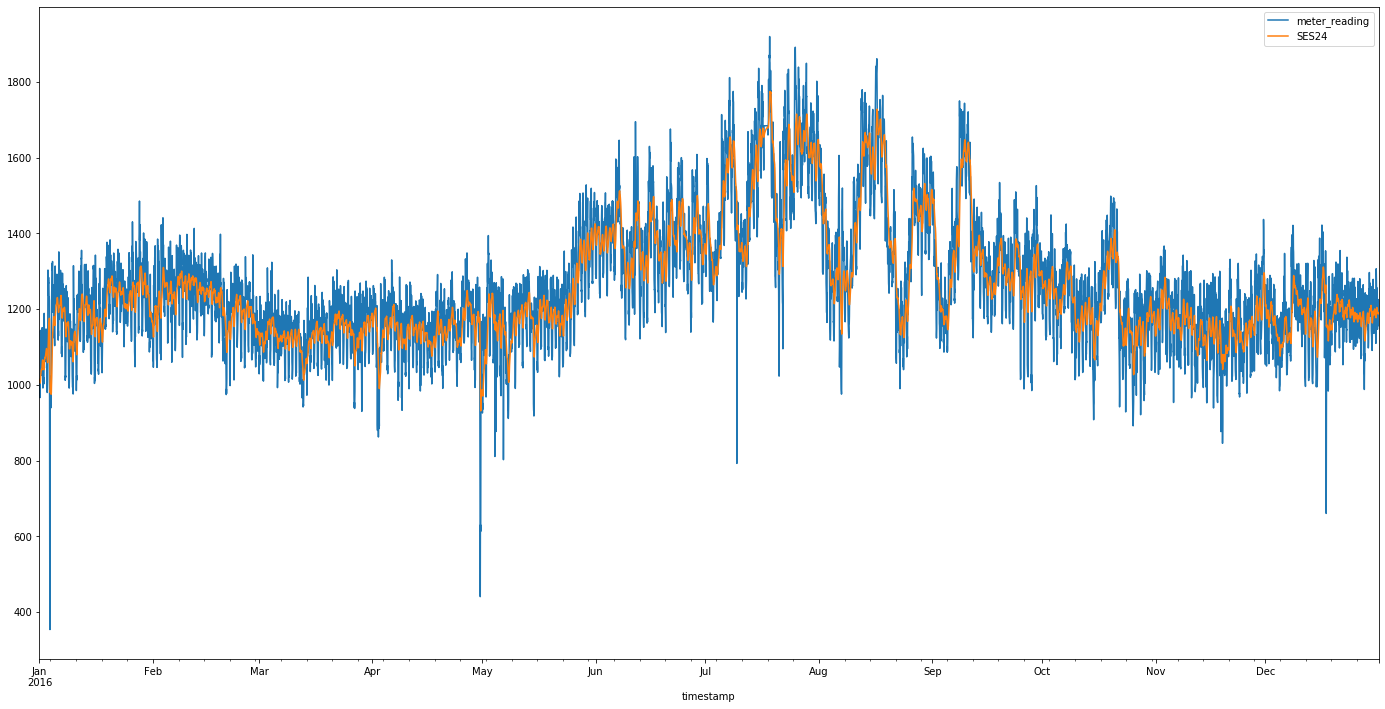

In [22]:
health_df_556.plot(figsize=(24,12))

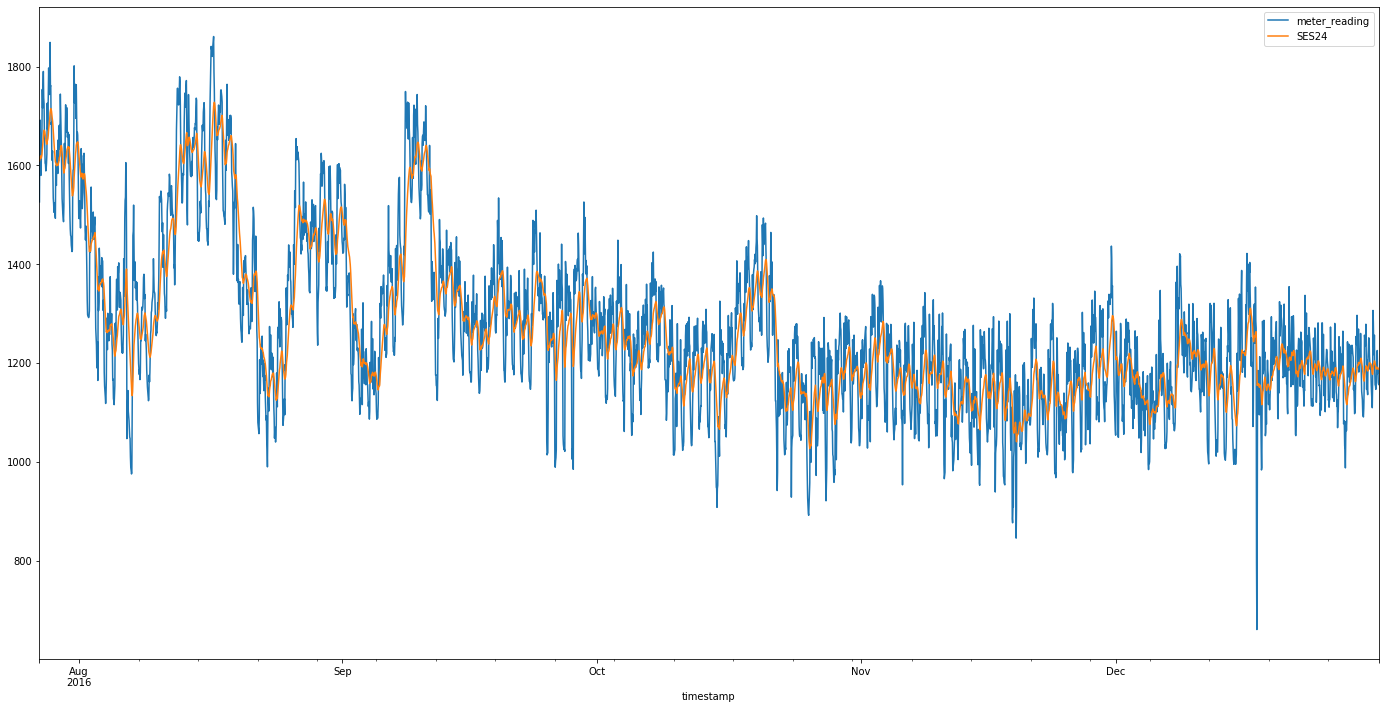

In [23]:
health_df_556.iloc[5000:].plot(figsize=(24,12))

In [24]:
#Double smoothing and tripple smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

health_df_556['DESadd24'] = ExponentialSmoothing(health_df_556['meter_reading'], trend='add').fit().fittedvalues.shift(-1)
health_df_556['TESadd24'] = ExponentialSmoothing(health_df_556['meter_reading'], trend='add',seasonal='add',seasonal_periods=24).fit().fittedvalues

In [25]:
health_df_556

,meter_reading,SES24,DESadd24,TESadd24
timestamp,,,,
2016-01-01 00:00:00,1013.780029,1013.780029,1013.797237,992.427966
2016-01-01 01:00:00,988.380005,1011.748023,988.397213,997.149915
2016-01-01 02:00:00,996.250000,1010.508178,996.267208,1012.579935
2016-01-01 03:00:00,966.219971,1006.965116,966.237178,990.922639
2016-01-01 04:00:00,984.390015,1005.159104,984.407222,1008.481971
...,...,...,...,...
2016-12-31 19:00:00,1225.359985,1191.459284,1225.377193,1191.239011
2016-12-31 20:00:00,1178.640015,1190.433740,1178.657222,1197.055501
2016-12-31 21:00:00,1187.449951,1190.195035,1187.467159,1142.731211


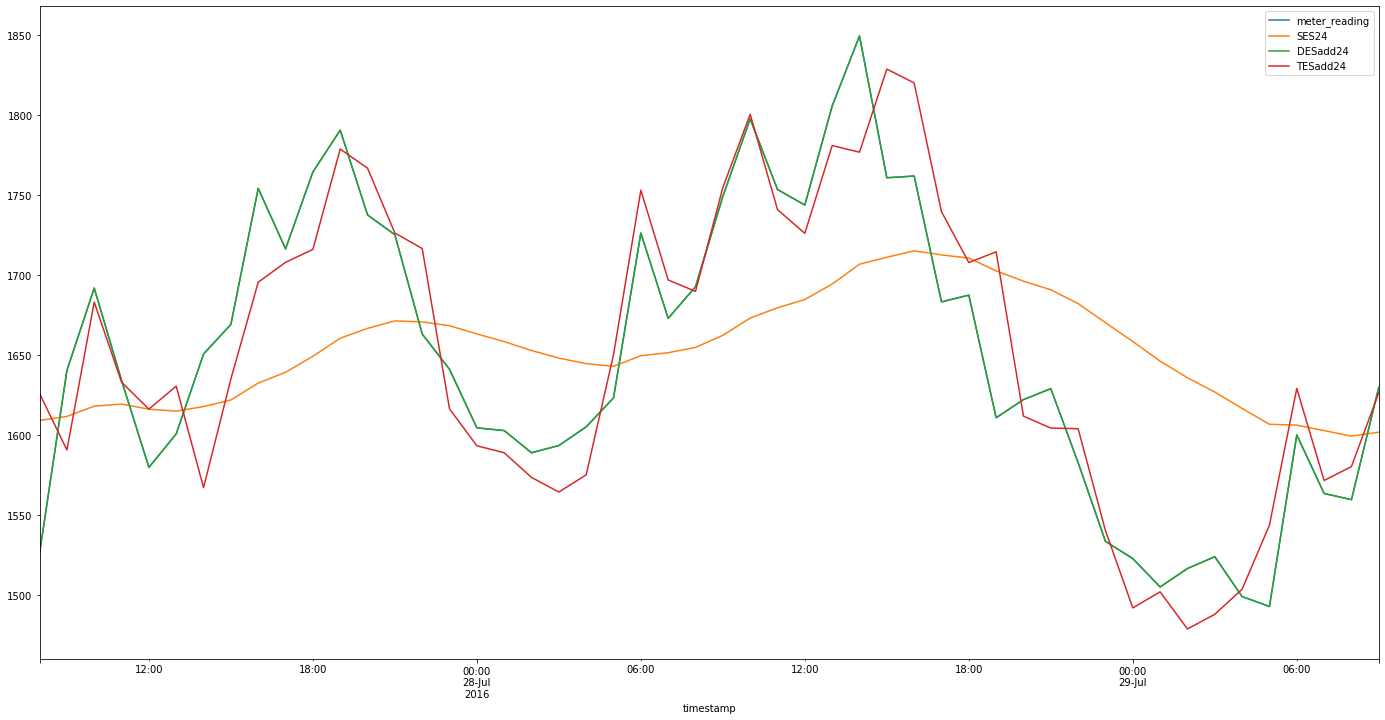

In [26]:
health_df_556.iloc[5000:5050].plot(figsize=(24,12))

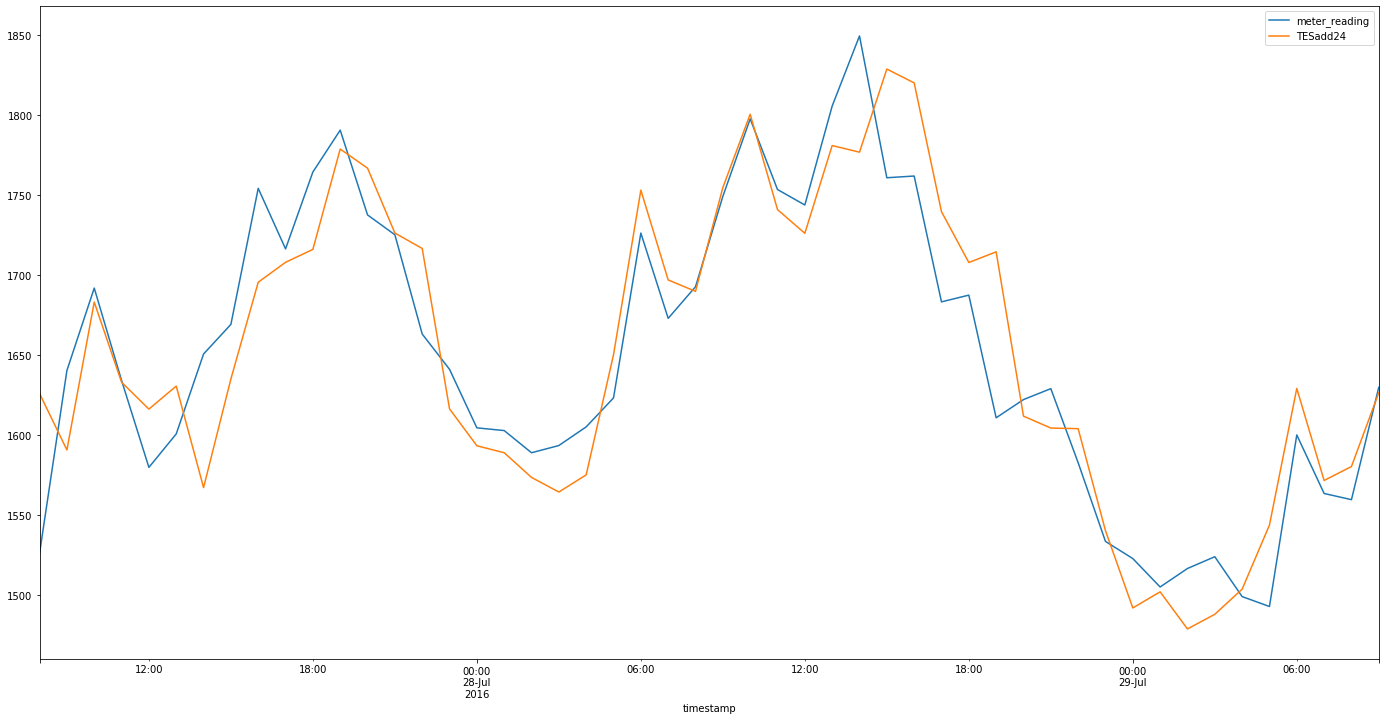

In [27]:
health_df_556[['meter_reading', 'TESadd24']].iloc[5000:5050].plot(figsize=(24,12))

In [28]:
#Double exponential smoothing gives best matching

In [29]:
#Checking for NaN and Inf

In [30]:
np.isnan(health_df_556.all()) 

meter_reading    False
SES24            False
DESadd24         False
TESadd24         False
dtype: bool

In [31]:
np.isinf(health_df_556.all()) 

meter_reading    False
SES24            False
DESadd24         False
TESadd24         False
dtype: bool

In [32]:
health_df_556.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   meter_reading  8784 non-null   float32
 1   SES24          8783 non-null   float64
 2   DESadd24       8783 non-null   float64
 3   TESadd24       8784 non-null   float64
dtypes: float32(1), float64(3)
memory usage: 308.8 KB


In [33]:
health_df_556.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


,meter_reading,SES24,DESadd24,TESadd24
timestamp,,,,
2016-01-01 00:00:00,1013.780029,1013.780029,1013.797237,992.427966
2016-01-01 01:00:00,988.380005,1011.748023,988.397213,997.149915
2016-01-01 02:00:00,996.250000,1010.508178,996.267208,1012.579935
2016-01-01 03:00:00,966.219971,1006.965116,966.237178,990.922639
2016-01-01 04:00:00,984.390015,1005.159104,984.407222,1008.481971
...,...,...,...,...
2016-12-31 19:00:00,1225.359985,1191.459284,1225.377193,1191.239011
2016-12-31 20:00:00,1178.640015,1190.433740,1178.657222,1197.055501
2016-12-31 21:00:00,1187.449951,1190.195035,1187.467159,1142.731211


In [34]:
health_df_556.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8784, freq='H')

In [35]:
np.isnan(health_df_556.all()) 

meter_reading    False
SES24            False
DESadd24         False
TESadd24         False
dtype: bool

In [36]:
#health_df_556.apply(lambda s: s[np.isfinite(s)].fillna(method='ffill'))

In [37]:
#np.isfinite(health_df_556.all()) 

In [38]:
#Remove previous fitting parameters
hc_df = health_df_556.drop(columns=['SES24','DESadd24','TESadd24'], axis = 1)

In [39]:
train_data = hc_df.iloc[:7001] # Goes up to but not including 109
test_data = hc_df.iloc[7000:]

In [40]:
train_data

,meter_reading
timestamp,
2016-01-01 00:00:00,1013.780029
2016-01-01 01:00:00,988.380005
2016-01-01 02:00:00,996.250000
2016-01-01 03:00:00,966.219971
2016-01-01 04:00:00,984.390015
...,...
2016-10-18 12:00:00,1371.939941
2016-10-18 13:00:00,1435.260010
2016-10-18 14:00:00,1378.880005


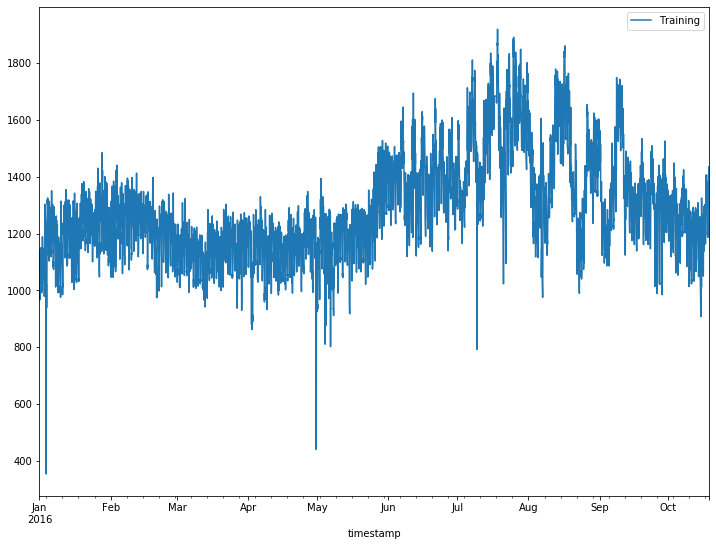

In [41]:
train_data['meter_reading'].plot(legend = True, label = 'Training', figsize=(12,9))


In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['meter_reading'],
                                    seasonal='mul',
                                    seasonal_periods=24).fit()

In [43]:
'''fitted_model = ExponentialSmoothing(train_data['meter_reading'],
                                    seasonal='mul',
                                    seasonal_periods=24).fit()'''

"fitted_model = ExponentialSmoothing(train_data['meter_reading'],\n                                    seasonal='mul',\n                                    seasonal_periods=24).fit()"

In [44]:
#ExponentialSmoothing(health_df_556['meter_reading'], trend='add').fit().fittedvalues.shift(-1)

In [45]:
type(fitted_model)

statsmodels.tsa.holtwinters.HoltWintersResultsWrapper

In [46]:
test_predictions = fitted_model.forecast(1784).rename('HW Forecast')

In [47]:
test_predictions 

2016-10-18 17:00:00    1386.585440
2016-10-18 18:00:00    1391.946130
2016-10-18 19:00:00    1415.676708
2016-10-18 20:00:00    1367.669099
2016-10-18 21:00:00    1350.132980
                          ...     
2016-12-31 20:00:00    1367.669099
2016-12-31 21:00:00    1350.132980
2016-12-31 22:00:00    1296.809348
2016-12-31 23:00:00    1257.264002
2017-01-01 00:00:00    1234.810223
Freq: H, Name: HW Forecast, Length: 1784, dtype: float64

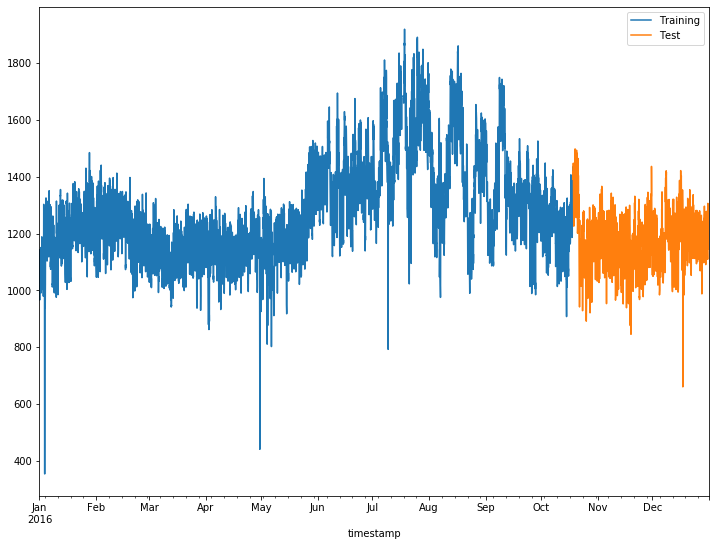

In [48]:
train_data['meter_reading'].plot(legend = True, label = 'Training', figsize=(12,9))
test_data['meter_reading'].plot(legend = True, label = 'Test', figsize=(12,9))

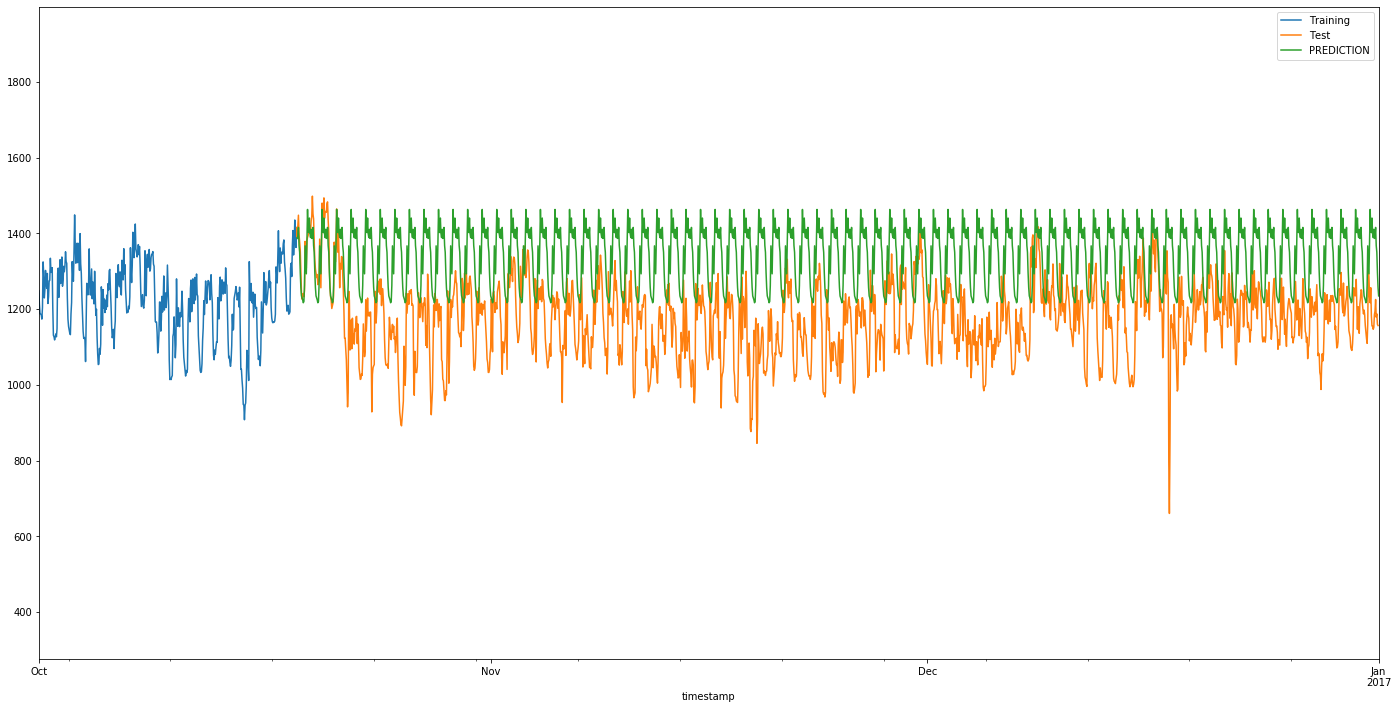

In [49]:
#Initial predictions of train/test split 
train_data['meter_reading'].plot(legend = True, label = 'Training', figsize=(24,12))
test_data['meter_reading'].plot(legend = True, label = 'Test', figsize=(24,12))
test_predictions.plot(legend=True,label='PREDICTION', xlim=['2016-10-01','2017-01-01 00:00:00 ']);

In [50]:
#Lets get some metrics goin
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [51]:
mean_absolute_error(test_data,test_predictions)

172.0643946441424

In [52]:
hc_df.describe()

,meter_reading
count,8784.000000
mean,1258.130249
std,171.736023
min,353.859985
25%,1145.457458
50%,1228.089966
75%,1339.517487
max,1919.719971


In [53]:
#We are off around 200kWh per hour on average of the mean of 1260 -> around 15% off
#Not amazing but not horrific
np.sqrt(mean_squared_error(test_data,test_predictions))

197.7695653477433

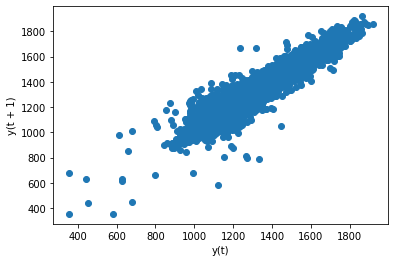

In [54]:
#Autocorrelation plot
from pandas.plotting import lag_plot

lag_plot(hc_df['meter_reading']);

In [55]:
#Shows considerable auto-correlation

In [56]:
#Looking specifically at PACF/ACF
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

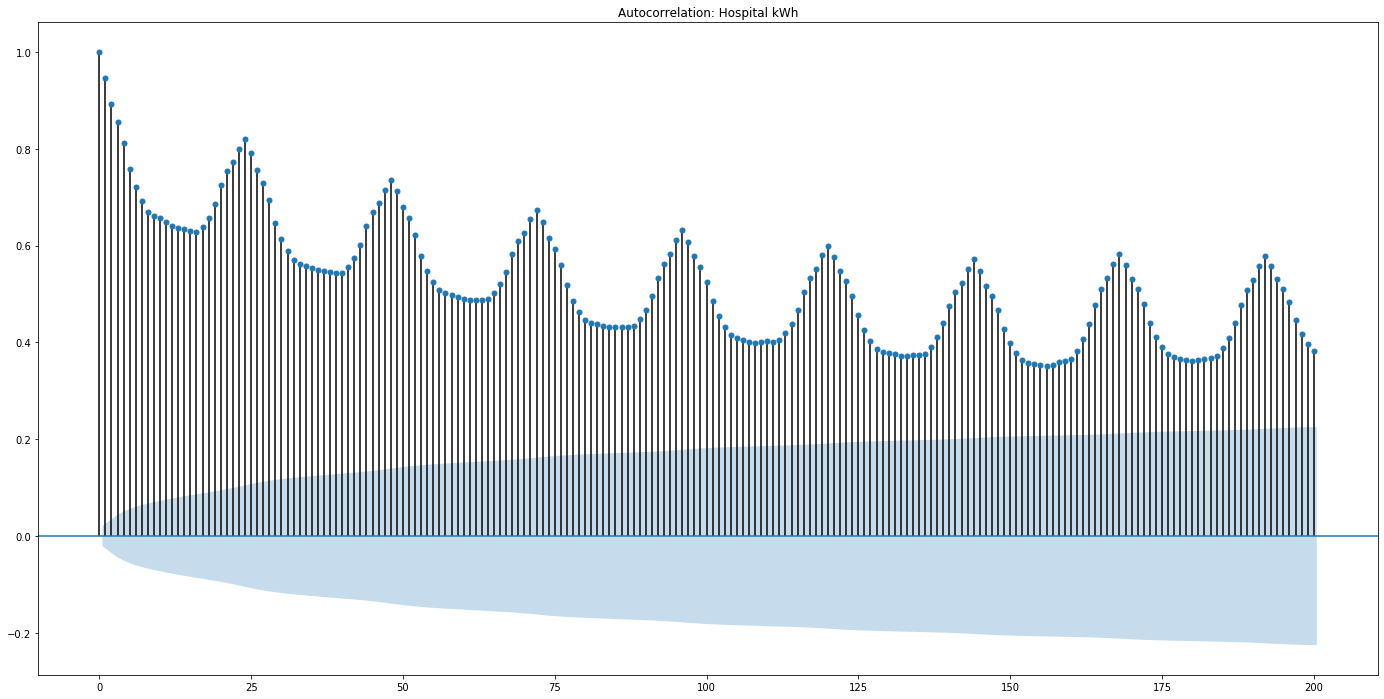

In [57]:
fig, ax = plt.subplots(figsize=(24,12))

lags = 200
plot_acf(hc_df,ax=ax,lags = lags, title = 'Autocorrelation: Hospital kWh');




In [58]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [59]:
adf_test(hc_df)

Augmented Dickey-Fuller Test: 
ADF test statistic        -5.343640
p-value                    0.000004
# lags used               35.000000
# observations          8748.000000
critical value (1%)       -3.431098
critical value (5%)       -2.861870
critical value (10%)      -2.566946
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


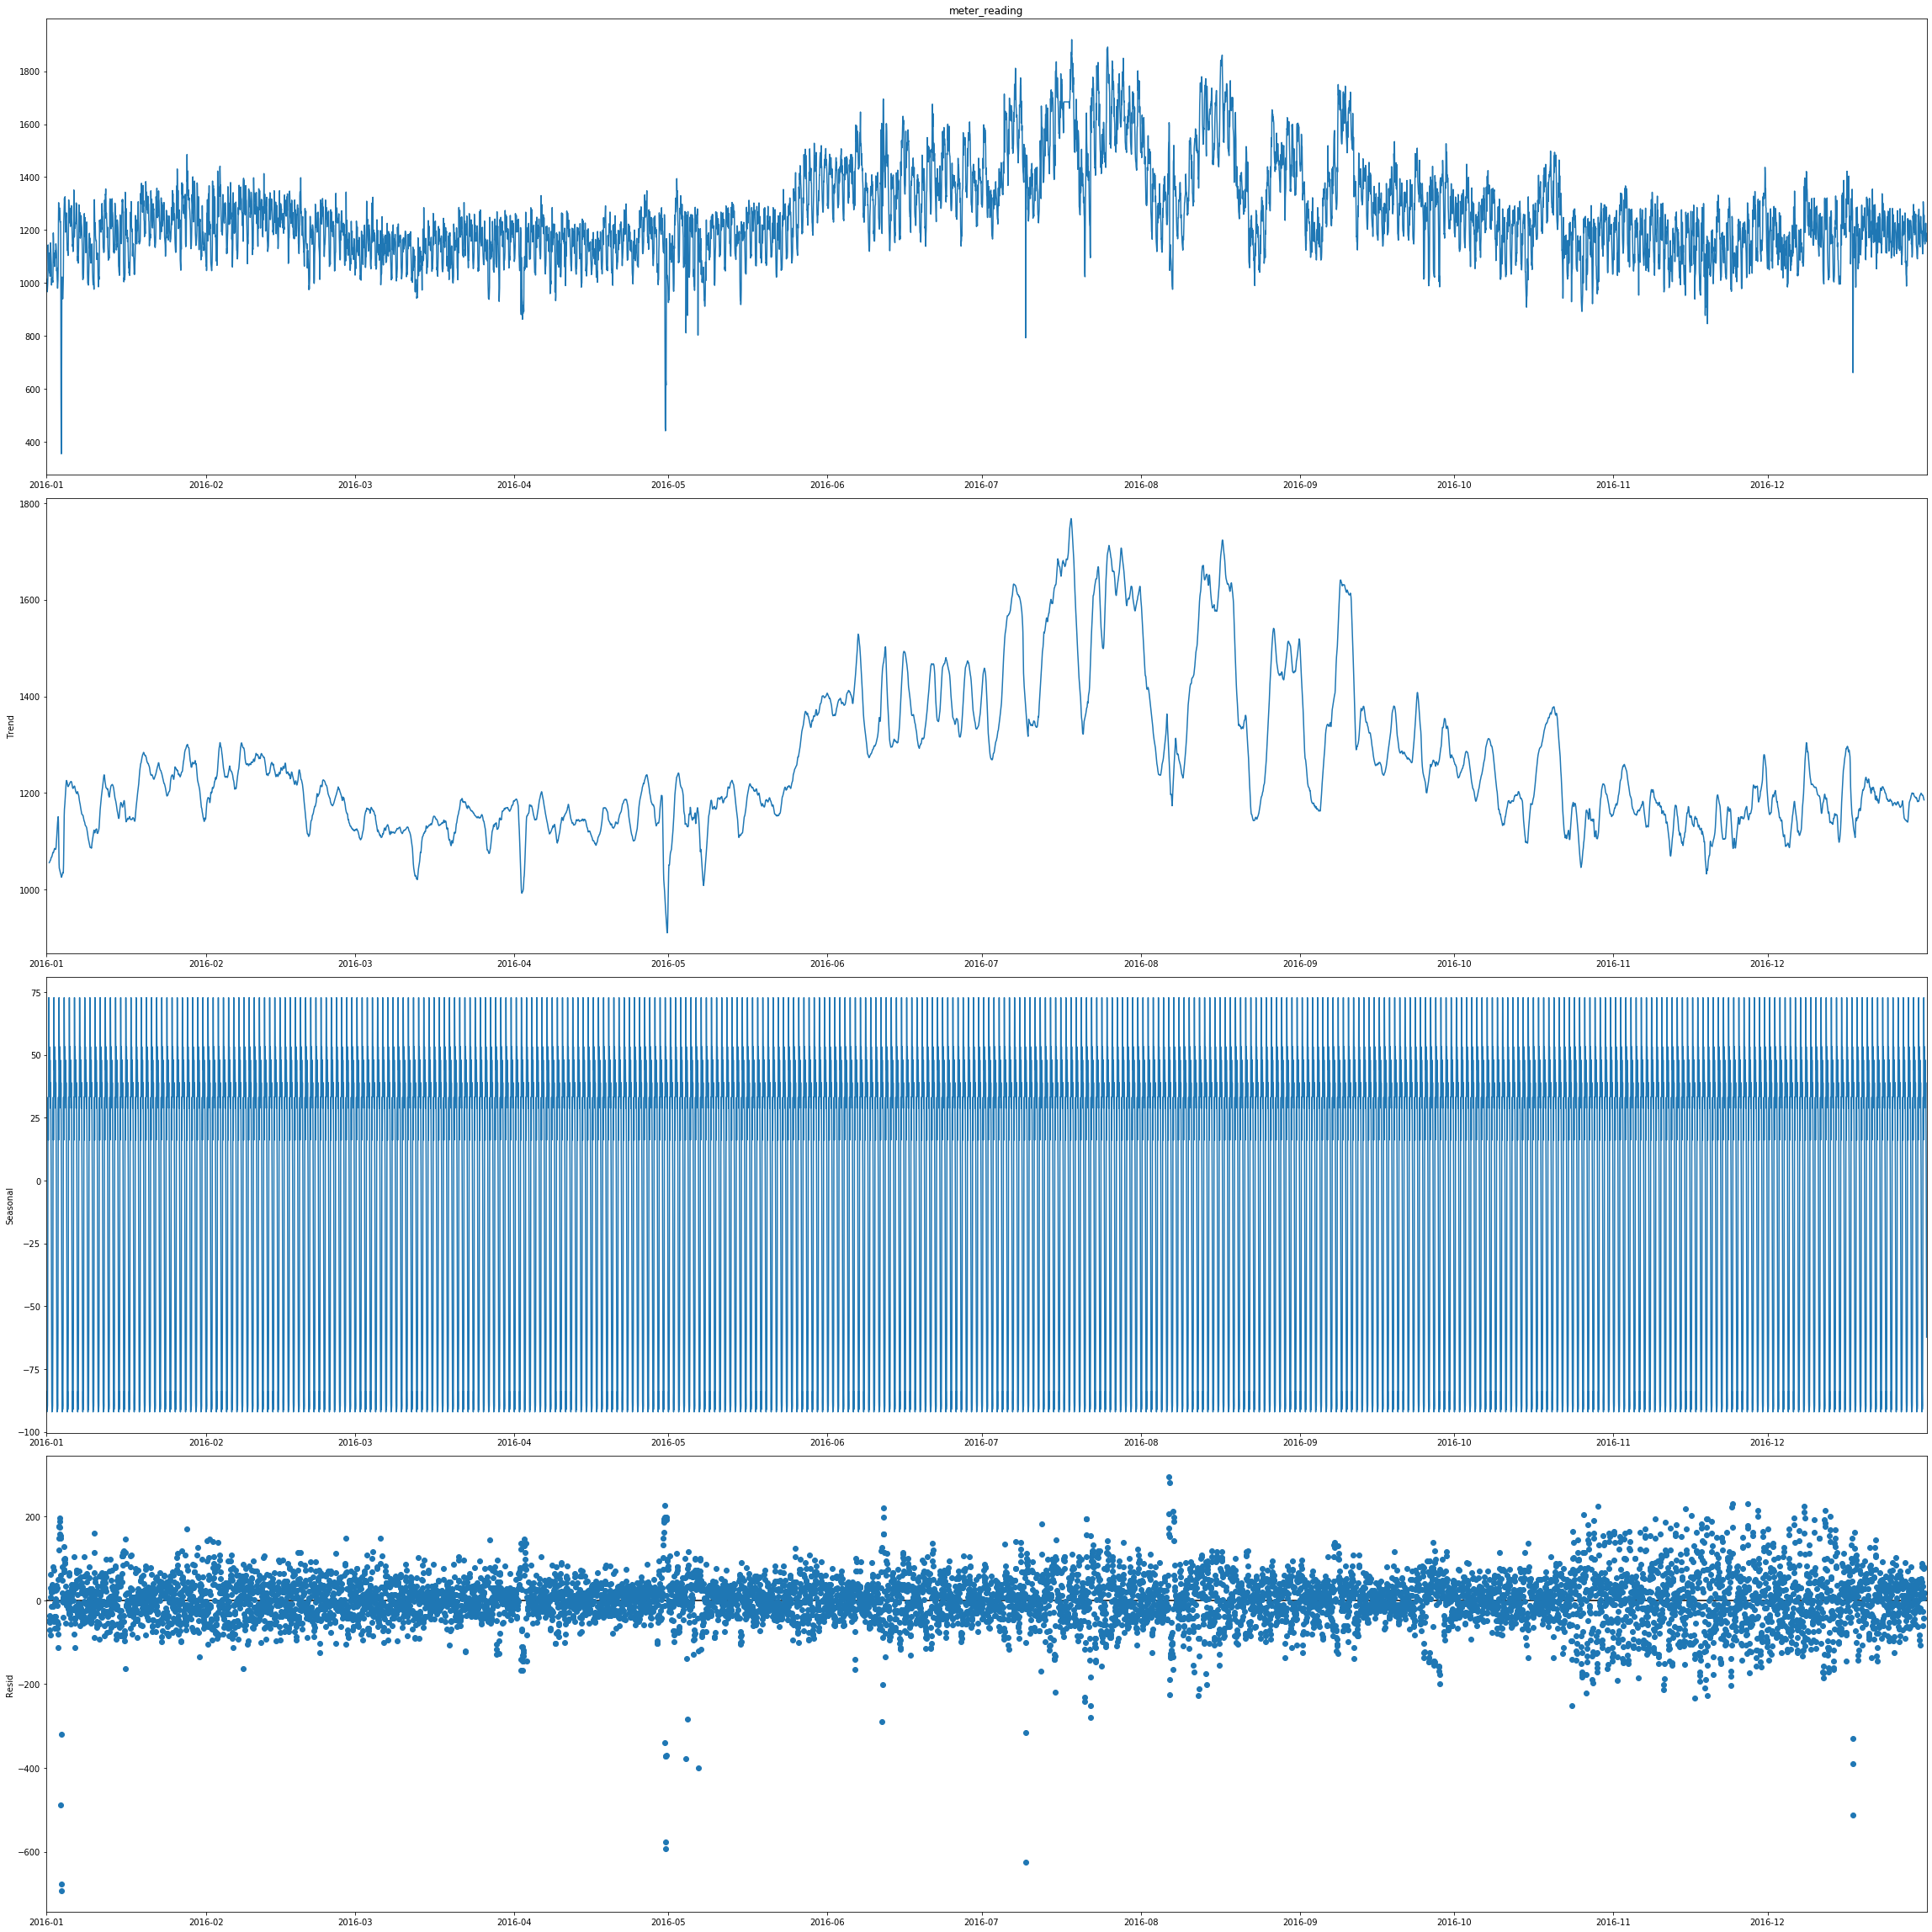

In [60]:
#Performing seasonal decomposition

from pylab import rcParams
rcParams['figure.figsize'] = 32,32
result = sm.tsa.seasonal_decompose(hc_df['meter_reading'], model='additive')
fig = result.plot()
plt.show()

In [61]:
#Clear seasonal component - zoom in!

In [62]:
result_zoom = sm.tsa.seasonal_decompose(hc_df['meter_reading'][500:800], model='additive')

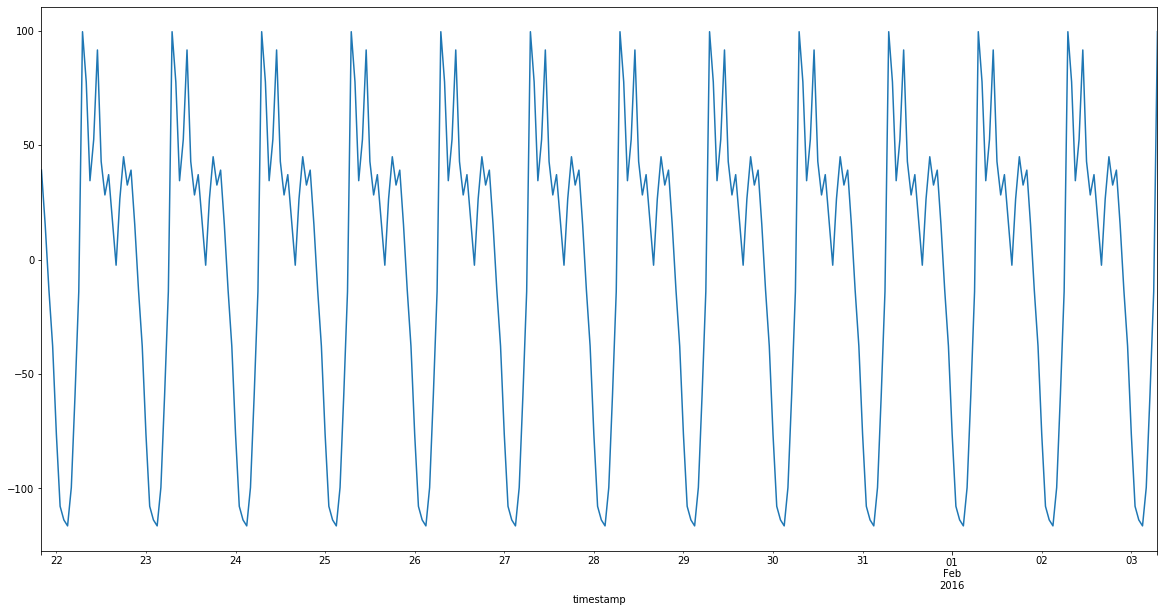

In [63]:
#Plot of seasonal component
result_zoom.seasonal.plot(figsize=(20,10))

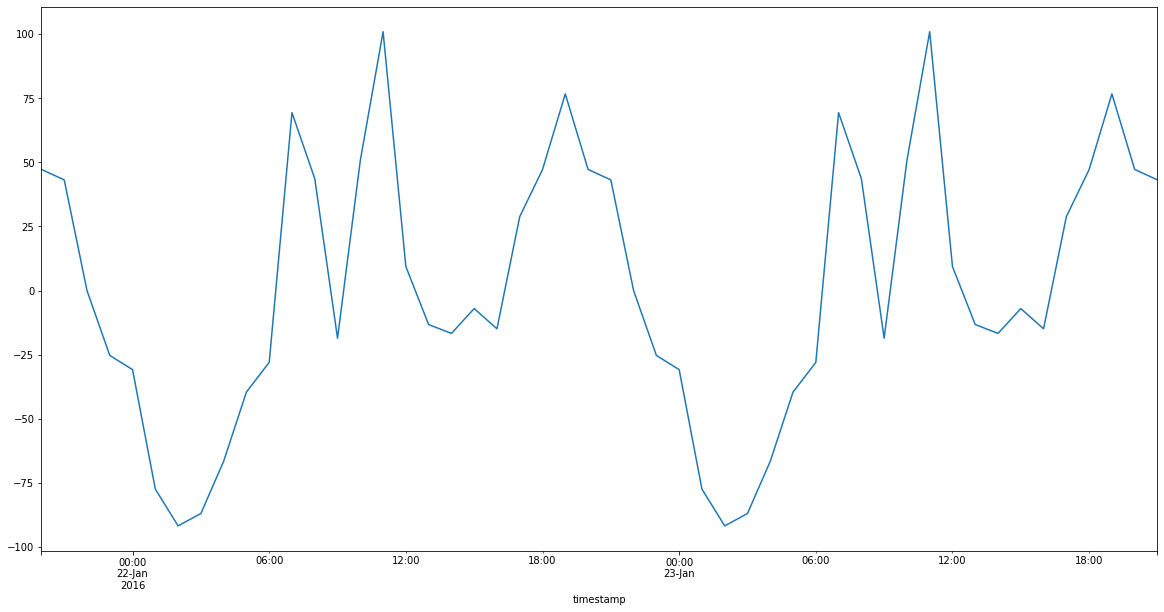

In [64]:
#Zoom in more to get hourly seasonal componet insights
result_zoom_more = sm.tsa.seasonal_decompose(hc_df['meter_reading'][500:550], model='additive')
result_zoom_more.seasonal.plot(figsize=(20,10))

In [65]:
#Can be seen that energy usage has morning and afternoon peaks with quiet nights -> as expected

In [66]:
#Can also see that seasonal component repeats every 24hrs from around 2am -> 60*24 = 1440

In [147]:
# For SARIMA Orders we set seasonal=True and pass in an m value
#auto_arima(hc_df['meter_reading'],seasonal=True,m=24, maxiter=1000, method = 'nm').summary()

In [64]:
#New train.test split as before

train = hc_df.iloc[:7001] 
test = hc_df.iloc[7000:]


In [65]:
# Load SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [66]:
model = SARIMAX(train['meter_reading'],order=(3,0,2),seasonal_order=(1,1,1,24),enforce_invertibility=False)
results = model.fit(maxiter=1000, method='nm')
results.summary()

Optimization terminated successfully.
         Current function value: 5.104266
         Iterations: 914
         Function evaluations: 1344


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        meter_reading   No. Observations:                 7001
Model:             SARIMAX(3, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -35734.969
Date:                              Tue, 09 Jun 2020   AIC                          71485.938
Time:                                      17:06:19   BIC                          71540.741
Sample:                                  01-01-2016   HQIC                         71504.825
                                       - 10-18-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9547      0.187      5.106      0.000       0.588       1.321
ar.L2          0.5093      0.321      1.586      0.113      -0.120       1.139
ar.L3         -0.4739      0.136     -3.478      0.001      -0.741      -0.207
ma.L1         -0.1208      0.186     -0.650      0.516      -0.485       0.243
ma.L2         -0.6147      0.164     -3.747      0.000      -0.936      -0.293
ar.S.L24       0.0377      0.010      3.657      0.000       0.018       0.058
ma.S.L24      -0.9205      0.005   -196.140      0.000      -0.930      -0.911
sigma2      1634.4338      9.240    176.879      0.000    1616.323    1652.545
===================================================================================
Ljung-Box (Q):                       71.16   Jarque-Bera (JB):            134694.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.89
Prob(H) (two-sided):                  0.84   Kurtosis:                        24.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
print(results.mle_retvals)

{'fopt': 5.161478353938803, 'gopt': array([ 5.60882896e-05,  6.11131208e-03,  2.01347872e-03,  1.24759471e-02,
       -1.73244574e-03, -5.08651494e-03, -1.79050108e-03, -3.77996301e-05]), 'fcalls': 531, 'warnflag': 1, 'converged': False, 'iterations': 50}


In [67]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(3,0,2)(1,1,1,24) Predictions')

In [68]:
# Comparing predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['meter_reading'][i]}")

predicted=1389.329747, expected=1415.2099609375
predicted=1397.849369, expected=1390.6300048828125
predicted=1421.853168, expected=1421.5
predicted=1370.538427, expected=1447.9599609375
predicted=1350.066473, expected=1396.719970703125
predicted=1293.961815, expected=1376.56005859375
predicted=1242.83191 , expected=1357.030029296875
predicted=1210.863436, expected=1299.5899658203125
predicted=1201.604882, expected=1244.1500244140625
predicted=1197.756154, expected=1226.31005859375
predicted=1191.286593, expected=1236.3900146484375
predicted=1198.103071, expected=1241.2099609375
predicted=1238.354779, expected=1232.7099609375
predicted=1344.28298 , expected=1248.3599853515625
predicted=1324.902282, expected=1378.8800048828125
predicted=1285.216667, expected=1336.760009765625
predicted=1345.874556, expected=1308.2099609375
predicted=1409.911302, expected=1380.43994140625
predicted=1354.035384, expected=1389.5799560546875
predicted=1347.437033, expected=1394.4200439453125
predicted=1387.7

[Text(0, 0.5, 'Meter Reading kWh'), Text(0.5, 0, '')]

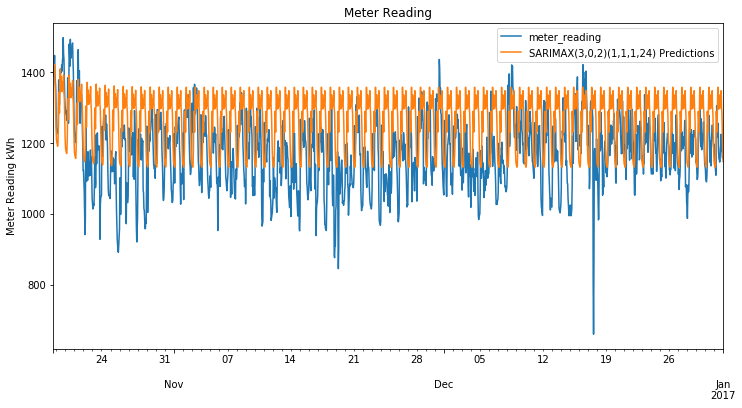

In [69]:
# Plot predictions against known values
title='Meter Reading'
ylabel='Meter Reading kWh'
xlabel=''

ax = test['meter_reading'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

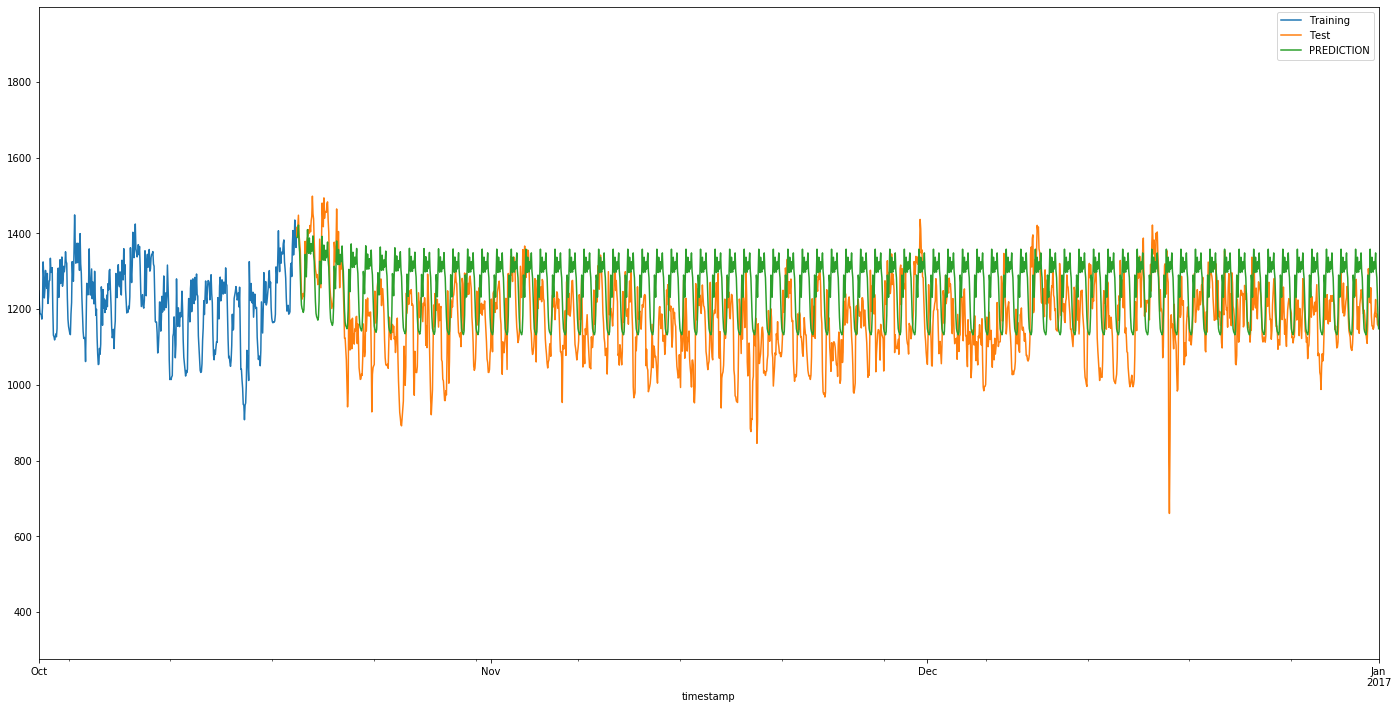

In [70]:
#Initial predictions of train/test split 
train['meter_reading'].plot(legend = True, label = 'Training', figsize=(24,12))
test['meter_reading'].plot(legend = True, label = 'Test', figsize=(24,12))
predictions.plot(legend=True,label='PREDICTION', xlim=['2016-10-01','2017-01-01 00:00:00 ']);

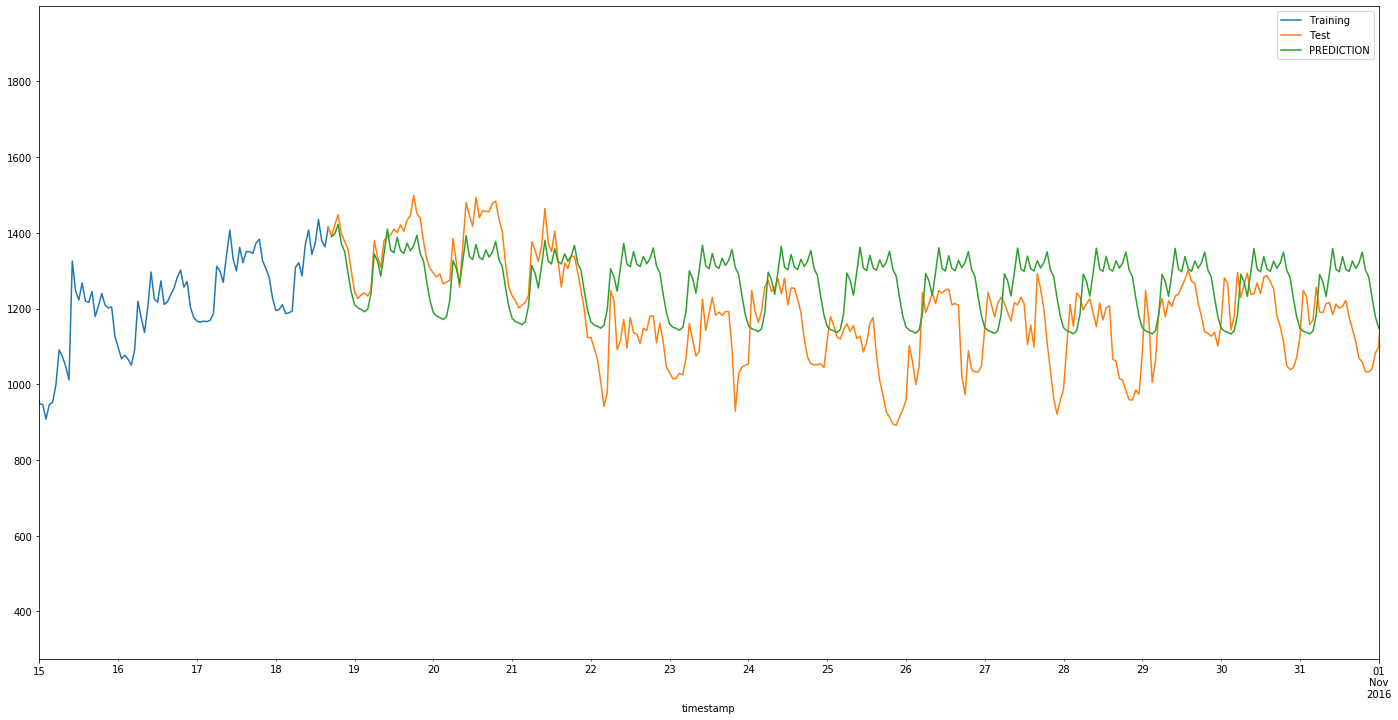

In [71]:
#Initial predictions of train/test split 
train['meter_reading'].plot(legend = True, label = 'Training', figsize=(24,12))
test['meter_reading'].plot(legend = True, label = 'Test', figsize=(24,12))
predictions.plot(legend=True,label='PREDICTION', xlim=['2016-10-15','2016-11-01 00:00:00 ']);

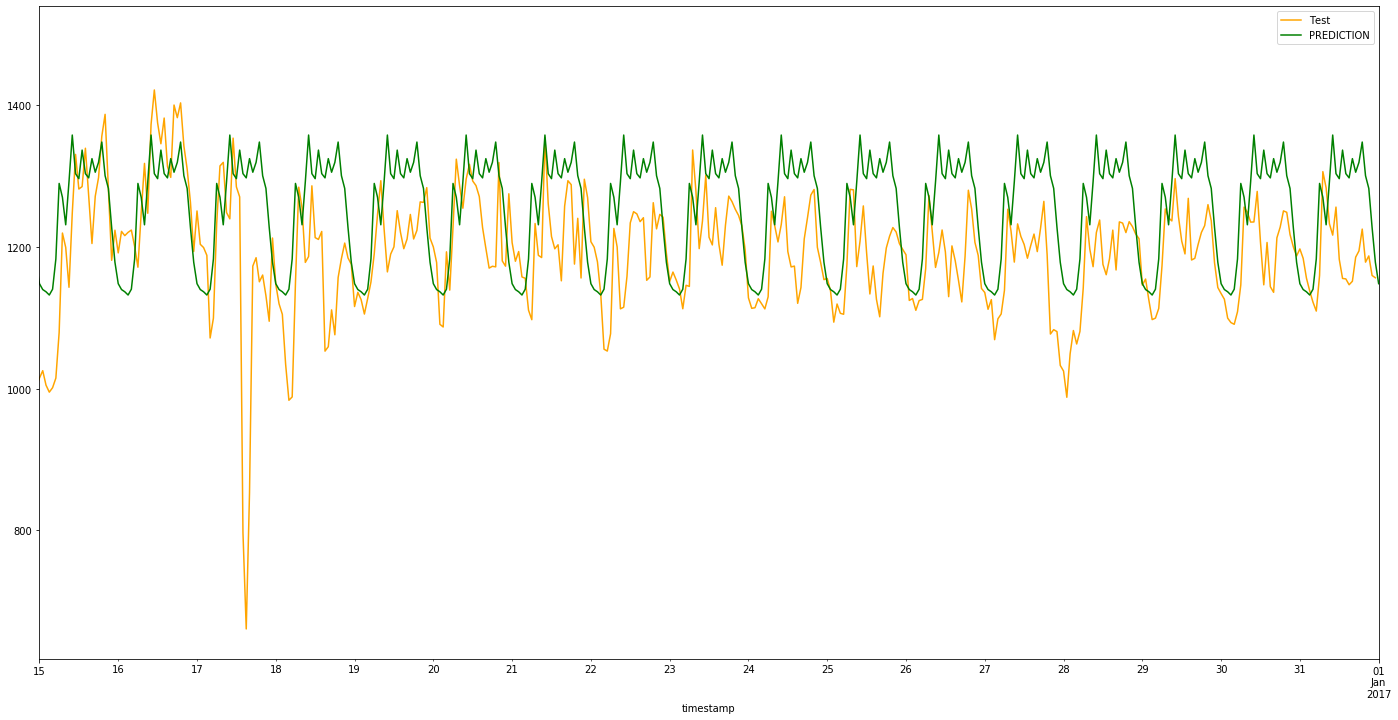

In [72]:
#Initial predictions of train/test split 
test['meter_reading'].plot(legend = True, label = 'Test', figsize=(24,12), color = 'orange')
predictions.plot(legend=True,label='PREDICTION', xlim=['2016-12-15','2017-01-01 00:00:00 '], color = 'green');

In [73]:
#Assess metrics

In [74]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

error1 = mean_squared_error(test['meter_reading'], predictions)
error2 = rmse(test['meter_reading'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 18444.20528
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 135.8094447


In [75]:
#Forecast into future
model = SARIMAX(hc_df['meter_reading'],order=(3,0,2),seasonal_order=(1,1,0,24),enforce_invertibility=False)
results = model.fit(maxiter=1000, method='nm')
fcast = results.predict(len(hc_df),len(hc_df)+200).rename('SARIMAX(3,0,2)(1,1,1,24) Forecast')

Optimization terminated successfully.
         Current function value: 5.299515
         Iterations: 744
         Function evaluations: 1134


[Text(0, 0.5, 'Meter Reading kWh'), Text(0.5, 0, '')]

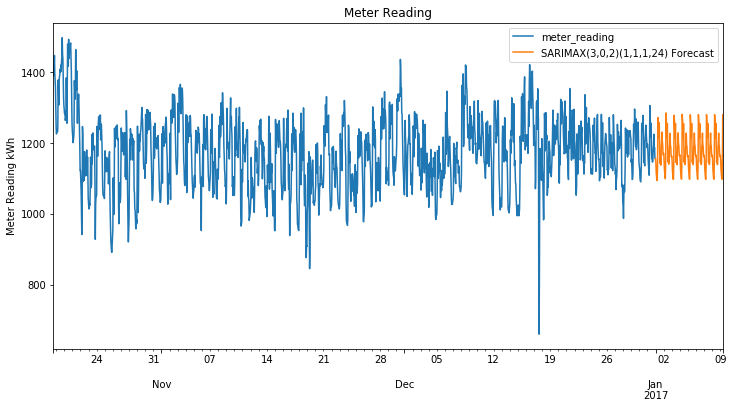

In [79]:
# Plot the forecast alongside historical values
title='Meter Reading'
ylabel='Meter Reading kWh'
xlabel=''

ax = test['meter_reading'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)